Step 1: Downloading the Dataset from kagglehub

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")

print("Path to dataset files:", path)

/home/sirlibzy/jupyter_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 48.6k/48.6k [00:00<00:00, 195kB/s]

Extracting files...
Path to dataset files: /home/sirlibzy/.cache/kagglehub/datasets/uciml/breast-cancer-wisconsin-data/versions/2


Step 2: Loading and Preparing the Data

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the breast cancer dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Create a DataFrame for better exploration
feature_names = cancer.feature_names
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['diagnosis'] = df['target'].map({0: 'malignant', 1: 'benign'})

# Split the data and scale features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dataset shape: {X.shape}")
print(f"Number of malignant samples: {np.sum(y == 0)}")
print(f"Number of benign samples: {np.sum(y == 1)}")

Dataset shape: (569, 30)
Number of malignant samples: 212
Number of benign samples: 357


In [6]:
# Identify important features using Random Forest
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Select top 10 features
top_indices = indices[:10]
selected_features = [feature_names[i] for i in top_indices]
X_train_selected = X_train_scaled[:, top_indices]
X_test_selected = X_test_scaled[:, top_indices]

# Print top features
print("Top 10 features by importance:")
for i, idx in enumerate(top_indices):
    print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")

Top 10 features by importance:
1. worst area: 0.1539
2. worst concave points: 0.1447
3. mean concave points: 0.1062
4. worst radius: 0.0780
5. mean concavity: 0.0680
6. worst perimeter: 0.0671
7. mean perimeter: 0.0533
8. mean radius: 0.0487
9. mean area: 0.0476
10. worst concavity: 0.0318


Step 3: Visualize Data with PCA

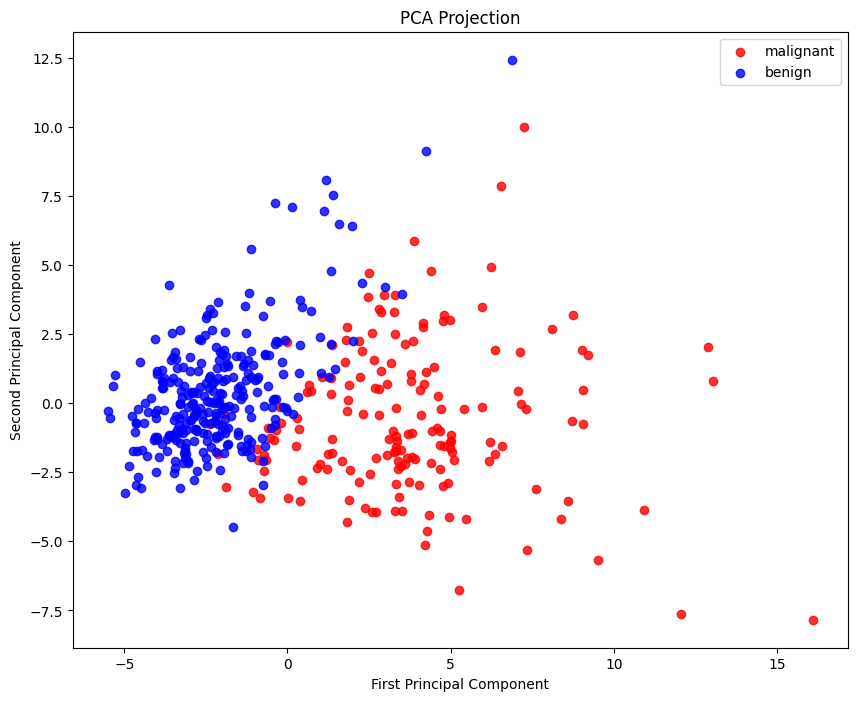

Total variance explained by 2 principal components: 0.63


In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Apply PCA ---
# Apply PCA to reduce to 2 dimensions
# Assumes X_train_scaled is already defined and preprocessed (e.g., scaled)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# --- Visualize data with PCA (Without Grid) ---
plt.figure(figsize=(10, 8))
colors = ['red', 'blue'] # Adjust based on the number of classes if different
for color, target, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(
        X_train_pca[y_train == target, 0], # x-coordinates (First PC)
        X_train_pca[y_train == target, 1], # y-coordinates (Second PC)
        color=color,
        alpha=0.8, # Make points slightly transparent
        label=target_name # Label for the legend
    )

# Add labels and title to the plot
plt.xlabel(f"First Principal Component")
plt.ylabel(f"Second Principal Component")
plt.title('PCA Projection') # You might want to add dataset name here

# Add a legend to identify the classes
plt.legend()
# Display the plot
plt.show()

# --- Calculate explained variance ---
# Calculate the total variance explained by the 2 components
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Total variance explained by {pca.n_components} principal components: {explained_variance:.2f}")

Step 4: Model Training and Evaluation

In [8]:
# Train and evaluate different models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")

# Create and evaluate a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', models['Logistic Regression']),
        ('svm', models['SVM']),
        ('rf', models['Random Forest'])
    ],
    voting='soft'
)

voting_clf.fit(X_train_selected, y_train)
y_pred_voting = voting_clf.predict(X_test_selected)
voting_accuracy = accuracy_score(y_test, y_pred_voting)
results['Voting Classifier'] = voting_accuracy
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

Logistic Regression Accuracy: 0.9737
SVM Accuracy: 0.9649
Random Forest Accuracy: 0.9561
Voting Classifier Accuracy: 0.9561


Step 5: Pipeline Integration

In [14]:
# Generate confusion matrix for the best model (Logistic Regression)
best_model = models['Logistic Regression']
y_pred_best = best_model.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:")
print(cm)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=cancer.target_names))

# Calculate sensitivity and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


Confusion Matrix:
[[42  1]
 [ 2 69]]

Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.98      0.97        43
      benign       0.99      0.97      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Sensitivity: 0.9718
Specificity: 0.9767
